# BertEncoder 성능 평가

In [8]:
from bert_feature.bert_encoder import BertFeatureExtractor
from tqdm import tqdm

/home/eden/anaconda3/envs/nlp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
import json

class G2PDataset(Dataset):
    def __init__(self, json_data, tokenizer, max_length=256):
        self.data = json_data["data"]
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        g2p_candidates = item["g2p_result"]
        target_sentence = item["sentence"]  # sentence is a list with 1 string


        return {
            
        }

def get_dataloader(json_path, tokenizer, batch_size=8, shuffle=True):
    with open(json_path, "r", encoding="utf-8") as f:
        json_data = json.load(f)
    dataset = G2PDataset(json_data, tokenizer)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


In [10]:
bert_encoder = BertFeatureExtractor()

Using device: cuda


In [11]:
dataloader = get_dataloader(
    '/home/eden/Documents/JNU/2025-1/Natural-Language-Processing/Natural-Language-Processing-Project/data/001.문서요약/1.Training_1216_add/Train_법률_data/train_original_preprocessed.json',
    bert_encoder.tokenizer,
    batch_size=1,
    shuffle=True,
    
)

In [12]:
json_path = '/home/eden/Documents/JNU/2025-1/Natural-Language-Processing/Natural-Language-Processing-Project/data/001.문서요약/1.Training_1216_add/Train_법률_data/train_original_preprocessed.json'
with open(json_path, "r", encoding="utf-8") as f:
        json_data = json.load(f)

In [37]:
all_similarities = []
to_get_similarities = json_data["data"][:20]  # Limit to 1000 samples for testing

g2p_vectors = []
target_vectors = []

for data in tqdm(to_get_similarities):
    g2p_candidates = data["g2p_result"]
    target_sentence = data["sentence"]  # sentence is a list with 1 string
    g2p_embedding = bert_encoder.extract_features(g2p_candidates, pooling_strategy='cls')
    target_embedding = bert_encoder.extract_features(target_sentence, pooling_strategy='cls')

    g2p_vectors.append(g2p_embedding.cpu().numpy())
    target_vectors.append(target_embedding)

    similarities = torch.tensor([torch.cosine_similarity(g2p_embedding, target_embedding).item() for g2p_embedding in g2p_embedding])
    all_similarities.append(similarities.mean())
    


100%|██████████| 20/20 [00:00<00:00, 94.95it/s]


In [38]:
print(g2p_vectors[0].shape)
print(target_vectors[0].shape)

(5, 768)
torch.Size([1, 768])


In [39]:
target_vectors = torch.cat(target_vectors, dim=0)
print(target_vectors.shape)

torch.Size([20, 768])


In [40]:
all_similarities = torch.stack(all_similarities)
print(all_similarities.shape)
print(all_similarities.mean())


torch.Size([20])
tensor(0.9648)


In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.cm as cm

def visualize_all_in_one(ground_truths, samples):
    assert len(ground_truths) == len(samples)
    N = len(ground_truths)

    # 전체 포인트와 색상 라벨을 모음
    all_vectors = []
    labels = []  # 0 ~ N-1 : 어떤 정답에 속하는 샘플인지

    for i in range(N):
        all_vectors.append(ground_truths[i])  # (784,)
        labels.append(i)  # Ground truth도 label 필요

        for sample in samples[i]:  # Mᵢ개
            all_vectors.append(sample)
            labels.append(i)

    all_vectors = np.stack(all_vectors)  # (N + ΣMᵢ, 784)

    # 차원 축소
    tsne = TSNE(n_components=2, perplexity=5, random_state=42)
    reduced = tsne.fit_transform(all_vectors)

    # 색 팔레트
    colors = cm.get_cmap('tab10', N)

    # 시각화
    plt.figure(figsize=(8, 8))
    plt.rcParams['pdf.fonttype'] = 42  # TrueType fonts
    plt.rcParams['ps.fonttype'] = 42   # For EPS output


    idx = 0
    for i in range(N):
        gt_coord = reduced[idx]
        num_samples = len(samples[i])
        sample_coords = reduced[idx + 1: idx + 1 + num_samples]

        # 정답 벡터 (별표)
        plt.scatter(gt_coord[0], gt_coord[1], color=colors(i), marker='*', s=200, label=f'Target {i}')

        # 샘플 벡터들 (점)
        plt.scatter(sample_coords[:, 0], sample_coords[:, 1], color=colors(i), marker='o', s=70, alpha=0.7)

        # 연결선
        for sc in sample_coords:
            plt.plot([gt_coord[0], sc[0]], [gt_coord[1], sc[1]], color=colors(i), alpha=0.4, linestyle='--')

        idx += 1 + num_samples

    plt.title("t-SNE Visualization of Text Embeddings")
    plt.axis('off')
    plt.legend()
    plt.tight_layout()
    plt.savefig("./Progress/figures/tsne_text_embeddings.pdf", format='pdf')
    plt.savefig("./Progress/figures/tsne_text_embeddings.svg", format='svg')
    

    plt.show()


/tmp/ipykernel_2985821/3470867156.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', N)


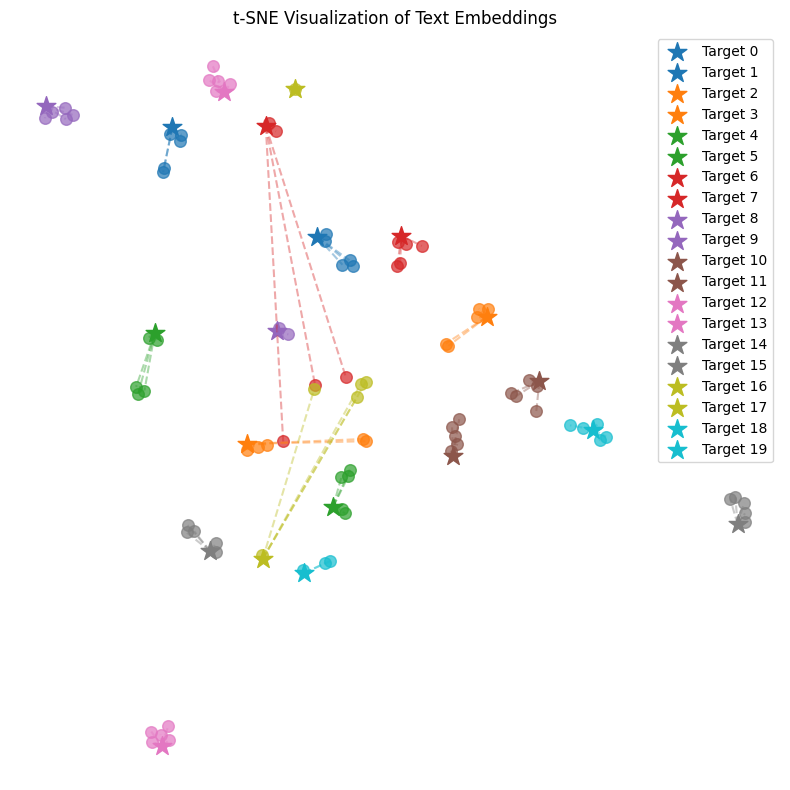

In [56]:
visualize_all_in_one(target_vectors.cpu().numpy(), g2p_vectors)

/tmp/ipykernel_2985821/804016702.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', N)


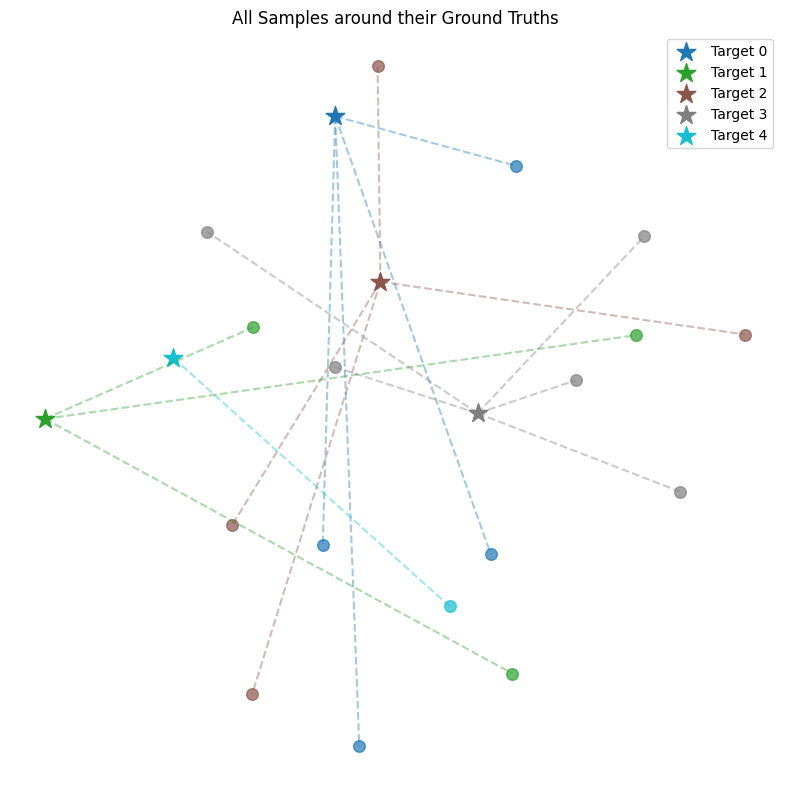

In [6]:
# 예시 데이터
N = 5
ground_truths = np.random.rand(N, 784)
samples = [np.random.rand(np.random.randint(1, 6), 784) for _ in range(N)]

visualize_all_in_one(ground_truths, samples)


# FusionEmbedding 성능 평가

In [16]:
for batch in dataloader:
    print(batch)
    g2p_mean_embedding = bert_encoder.extract_features(batch, pooling_strategy="mean")


    similarities = [torch.cosine_similarity(bert_encoder[0], bert_encoder[i]) for i in range(1, len(batch["g2p_results"]))]


[('타인의 등록상표와 동일 또는 유사한 표장을 이용한 경우라고 하더라도 그것이 상표의 본질적인 기능이라고 할 수 있는 출처표시를 위한 것이 아니라 순전히 디자인적으로만 사용되는 등으로 상표의 사용으로 인식될 수 없는 경우에는 등록상표의 상표권을 침해한 행위로 볼 수 없고,',), ('타인의 등록쌍표와 동일 또는 유사한 표장을 이용한 경우라고 하더라도 그것이 상표의 본질적인 기능이라고 할 쑤 있는 출처표시를 위한 것이 아니라 순전히 디자인적으로만 사용되는 등으로 상표의 사용으로 인식될 쑤 없는 경우에는 등록쌍표의 상표권을 침해한 행위로 볼 쑤 없고,',), ('타이늬 등록상표와 동일 또는 유사한 표장을 이용한 경우라고 하더라도 그거시 상표의 본질저긴 기능이라고 할 쑤 인는 출처표시를 위한 거시 아니라 순전히 디자인저그로만 사용되는 등으로 상표의 사용으로 인식될 쑤 없는 경우에는 등록상표의 상표궈늘 침해한 행위로 볼 쑤 없고,',), ('타이늬 등록쌍표와 동일 또느 뉴사한 표장으 리용한 경우라고 하더라도 그거시 상표의 본질저긴 기능이라고 할 쑤 있는 출처표시르 뤼한 거시 아니라 순전히 디자인저그로만 사용되는 등으로 상표의 사용으로 인식될 쑤 없는 경우에는 등록쌍표의 상표궈늘 침해한 행위로 볼 쑤 없고,',), ('타인의 등록쌍표와 동일 또느 뉴사한 표장으 리용한 경우라고 하더라도 그것이 상표의 본질적인 기능이라고 할 쑤 있는 출처표시르 뤼한 것이 아니라 순전히 디자인적으로만 사용되는 등으로 상표의 사용으로 인식될 쑤 없는 경우에는 등록쌍표의 상표권을 침해한 행위로 볼 쑤 없고,',), ('타이늬 등록상표와 동일 또느 뉴사한 표장으 리용한 경우라고 하더라도 그거시 상표의 본질저긴 기능이라고 할 수 있는 출처표시르 뤼한 거시 아니라 순전히 디자인저그로만 사용되는 등으로 상표의 사용으로 인식뙬 수 없는 경우에는 등록상표의 상표궈늘 침해한 행위로 볼 수 없고,',)]


ValueError: not enough values to unpack (expected 2, got 1)